In [2]:
# added seed arguments where necessary
import numpy as np
import pandas as pd
import string
import re
import os
from transformers import AutoModel
from transformers import AutoTokenizer

In [3]:
# this notebook was ran on Google Colab, with the data residing in Google Drive. Therefore, you need to "mount" onto Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.listdir('./')

['.config', 'drive', 'sample_data']

**Step 1: Confirm Dataset is Complete**
We need to ensure the dataset contains everything it is supposed to contain. In this section, I mainly check that each clinical note is accompanied by an annotation (conecpt file).

This is an especially good habit in industry where data vendors will often provide incomplete data or data in an unexpected format.

In [5]:
suffix = 'drive/MyDrive/medical_dataset_analysis/'
beth_file_directory = 'concept_assertion_relation_training_data/beth/txt/'
beth_train_files = os.listdir(suffix+beth_file_directory)
beth_train_files.remove('.DS_Store')
print("Number of clinical notes (for training) from Beth institute:",len(beth_train_files))

Number of clinical notes (for training) from Beth institute: 73


In [6]:
beth_concept_directory = 'concept_assertion_relation_training_data/beth/concept/'
beth_concept_files = os.listdir(suffix+beth_concept_directory)
print("Number of concept files (for training) from Beth institute:",len(beth_concept_files))

Number of concept files (for training) from Beth institute: 73


In [7]:
partner_file_directory = 'concept_assertion_relation_training_data/partners/txt/'
partner_train_files = os.listdir(suffix+partner_file_directory)
print("Number of clinical notes (for training) from partners other than Beth:",len(partner_train_files))

Number of clinical notes (for training) from partners other than Beth: 97


In [8]:
partner_concept_directory = 'concept_assertion_relation_training_data/partners/concept/'
partner_concept_files = os.listdir(suffix+partner_concept_directory)
print("Number of concept files (for training) from partners other than Beth:",len(partner_concept_files))

Number of concept files (for training) from partners other than Beth: 97


In [9]:
all_train_files = partner_train_files + beth_train_files
print("Total number of notes for training:", len(all_train_files))

Total number of notes for training: 170


In [10]:
test_directory = 'test_data/'
test_files = os.listdir(suffix+test_directory)
print("Number of clinical notes for testing:",len(test_files))

Number of clinical notes for testing: 256


In [11]:
test_directory_concepts = 'reference_standard_for_test_data/concepts/'
concept_test_files = os.listdir(suffix+test_directory_concepts)
print("Number of concept files for testing:",len(concept_test_files))

Number of concept files for testing: 256


There seems to be 256 notes for testing, but only 170 notes for training. To fully replicate the 2010 challenge this data was based on, I would need to split my training and testing in this manner. However, my goal is to achieve the highest F1-score possible, so I will combine the training and test and leave out only 10% or 20% for testing.

In [12]:
beth_set_notes = set(list(map(lambda x: re.findall('[0-9]{2,3}',x)[0],beth_train_files)))
beth_set_cons = set(list(map(lambda x: re.findall('[0-9]{2,3}',x)[0],beth_concept_files)))

Next, let's confirm that each clinical note maps to a concept file

In [13]:
len(beth_set_notes.intersection(beth_set_cons))

73

In [14]:
partner_set_notes = set(list(map(lambda x: x[:-4],partner_train_files)))
partner_set_cons = set(list(map(lambda x: x[:-4],partner_concept_files)))

In [15]:
intersection_partner_set = set(partner_set_notes.intersection(partner_set_cons))

In [16]:
len(intersection_partner_set)

97

In [17]:
def getNotes(file_directory):
    '''
    Input: string representing file path of directory
    Output: dictionary where the key is the clinical note id and the value is the raw text from the file
    '''
    text_dict = {}
    file_list = os.listdir(suffix+file_directory)
    for f in file_list:
        if f[-3:] != 'xml' and f[-3:] != 'txt' and f[-3:] != 'con':
            file_list.remove(f)
    if '.DS_Store' in file_list:
        file_list.remove('.DS_Store')
    for file_name in file_list:
        with open(suffix+file_directory + file_name,'r') as file:
            data = file.read()
            text_dict[file_name[:-4]] = data
        file.close()
    return text_dict

In [18]:
beth_notes = getNotes(beth_file_directory)
beth_concepts = getNotes(beth_concept_directory)
partners_notes = getNotes(partner_file_directory)
partners_concepts = getNotes(partner_concept_directory)

In [19]:
a = set(list(beth_concepts.keys()))
b = set(list(beth_notes.keys()))

In [20]:
len(a.intersection(b))

73

In [21]:
c = set(list(partners_notes.keys()))
d = set(list(partners_concepts.keys()))

In [22]:
len(c.intersection(d))

97

In [23]:
all_notes = beth_notes.copy()
all_notes.update(partners_notes)

In [24]:
len(list(all_notes.keys()))

170

In [25]:
all_concepts = beth_concepts.copy()
all_concepts.update(partners_concepts)

In [26]:
len(list(all_concepts.keys()))

170

In [27]:
test_notes = getNotes(test_directory)
test_concepts = getNotes(test_directory_concepts)

In [28]:
e = set(list(test_notes.keys()))
f = set(list(test_concepts.keys()))

In [29]:
len(e.intersection(f))

256

In [30]:
all_notes.update(test_notes)
all_concepts.update(test_concepts)

In [31]:
g = set(list(all_concepts.keys()))
h = set(list(all_notes.keys()))

In [32]:
len(list(g.intersection(h)))

426

Now that we have the data in dictionaries, we need to preprocess the annotations so that they are in a format suitable for Named Entity Recognition. When a word has an annotation, the annotation will be tagged with a B or an I depending if it is the beginning of the annotation or not. For words without an annotation, they will be tagged with O, meaning there is no relevant concept to annotate.

Also, I have split the data on white spaces as a start, but depending on the model I use I will have to modify this tokenization since tokenizers vary by model.

In [33]:
start_tag = 'B'
inner_tag = 'I'
null_tag = 'O'

In [34]:
data = {}

for record in all_concepts.keys():
    data[record] = {'words':[],'tags':[]}
    ns = all_notes[record]
    cs = all_concepts[record]
    lines = ns.split('\n')
    concept_lines = cs.split('\n')[:-1]

    lines_with_concepts = {}

    for concept_index, concept_line in enumerate(concept_lines):
        note_line = re.findall('[0-9]{1,3}:',concept_line)[0][:-1]
        word_nums = list(map(lambda x: int(x[1:]),re.findall(':[0-9]{1,3}',concept_line)))
        lines_with_concepts[(note_line,str(concept_index))] = word_nums

    for tup, word_nums in lines_with_concepts.items():

        insert_dict = {}

        notes_index, concepts_index = tup

        the_words = lines[int(notes_index)-1].split(' ')
        tags = [null_tag]*len(the_words)
        for word_num in range(word_nums[0],word_nums[-1]+1):
            tag_type = re.findall(r't=\"[a-z]+\"',concept_lines[int(concepts_index)])[0][3:-1]
            if word_num == min(word_nums) and len(word_nums)<3:
                tags[word_num] = start_tag + '-' + tag_type
            else:
                if len(word_nums) < 3:
                    tags[word_num] = inner_tag + '-' + tag_type
        data[record]['words'] += the_words
        data[record]['tags'] +=  tags

Because I plan on working with a BERT model, the maximum tokens allowed are 512, meaning I need to ensure all samples are 512 tokens or less.

In [35]:
data_copy = data.copy()
for note in data.keys():
  num = len(data[note]['words'])
  times = num // 512
  for i in range(times):
    data_copy[note+'-'+str(i)] = {'words': data_copy[note]['words'][i*512:(i+1)*512],'tags': data_copy[note]['tags'][i*512:(i+1)*512]}
    if i == times - 1:
      data_copy[note+'-'+str(i+1)] = {'words': data_copy[note]['words'][(i+1)*512:],'tags': data_copy[note]['tags'][(i+1)*512:]}
  del data_copy[note]

In [36]:
df = pd.DataFrame(data_copy)
df_trans = df.transpose()

In [37]:
samples = df_trans.loc[['0073-1','0253-0','0406-4','0138-0','record-124-4','0089-3','record-82-3','0313-12','523704694-7','0061-4']]

Next, it is time to verify that the annotations are complete. To accomplish this, I took a random sample of 10 notes and looked at the first 10 tokens of each. I found 14% error rate. However, the content of these notes are extremely technical and were written by a skilled physician with the intention of being read by other skills physicians. Therefore, there might be some cruical nuances that I, a non-professional, am unable to detect. Therefore, I will continue this project with the assumption that the annotations are in fact complete.

Please note that I promised the proprietors of this data I would not share the data with anyone besides my mentor, even though it is fully deidentified. Therefore, I have omitted the output of certain cells from this notebook. If you are a grader and want to further confirm the validity of this notebook, please reach out to my bootcamp mentor, Kyle McGrath.

In [ ]:
samples['words10'] = samples['words'].apply(lambda x: x[0:10])
samples['tags10'] = samples['tags'].apply(lambda x: x[0:10])
samples

In [ ]:

'''

Here are the number of annotations I believe are missing from each sample:

0073-1: 0
0253-0: 0
0406-4: 0
0138-0: 0
record-124-4: 0
0089-3: 3
record-82-3: 0
0313-12: 2
523704694-7: 6
0061-4: 3

total: 14

rate: 14/100 = 14%

'''
samples[['words10','tags10']]

In [40]:
# Split data between input variables, X, and target variables, y
X = df_trans['words']
y = df_trans['tags']

In [41]:
# series = df_trans['words']

# vocab = []

# for record in series.index:
#   for word in series.loc[record]:
#     if word.lower() not in vocab:
#       vocab.append(word.lower())

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.DataFrame(data)
df_trans2 = df.transpose()

series = df_trans2['words']

documents = list()

for record in series.index:
  words = " ".join(series.loc[record])
  documents.append(words)

vec = TfidfVectorizer(analyzer='word' , stop_words='english')
X = vec.fit_transform(documents)

In [48]:
df_tfidf = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out(), index = series.index)
df_tfidf

,00,000,0004,0028,005,008,00pm,01,010,013,...,zonegran,zonisamide,zoster,zosyn,zpak,zv061,zygoma,zygomal,zyprexa,zyrtec
record-22,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
record-105,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
record-30,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
record-83,0.007949,0.005636,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
record-14,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.081977,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0393,0.000000,0.002222,0.0,0.0,0.0,0.0,0.0,0.013618,0.022595,0.0,...,0.056488,0.005649,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0421,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
0433,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [175]:
# words_of_interest = ['surgery']
# df_tfidf.max().sort_values(ascending=False)[words_of_interest]
# # doctors = {}
# # for record in all_notes.keys():
# #     matches = re.search('[Attending.+[A-Za-z\.\s,]+\sM\.D\.',all_notes[record][0:300])
# #     try:
# #       one_match = matches.group().strip()
# #       if one_match not in doctors.keys():
# #         doctors[one_match] = 1
# #       else:
# #         doctors[one_match] += 1
# #     except:
# #       _
# # print(doctors)

surgery    0.141455
dtype: float64

In [199]:
# y = []
# word = 'hypertension'
# for record in df_tfidf.index:
#   new_df = df_tfidf.loc[record]
#   if new_df['hypertension'] > 0.01 or new_df['heart'] > 0.01 or new_df['coronary'] > 0.01:
#     y.append(word)
#   else:
#     y.append("non " + word)

I transformed my data using TD-IDF and then placed the resulting matrix into TSNE, a dimension reduction technique. The result is a 2D visualization showing 4 distinct groups. I tried color-coding each document by institute and by doctor, but neither resulted in groups like in the TSNE visualization. I'll have to keep exploring!

/usr/local/lib/python3.10/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


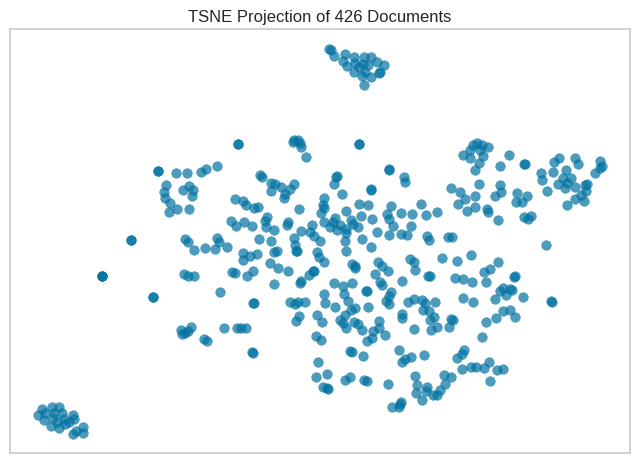

<Axes: title={'center': 'TSNE Projection of 426 Documents'}>

In [201]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(X)
tsne.show()

97
